# LOGISTIC REGRESSION

In [40]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Data
X_train_df = pd.read_csv('gold/X_train_df.csv', index_col='respondent_id') # training set features

training_set_labels_df = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id') # training set labels

X_test_df = pd.read_csv('gold/X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('data/submission_format.csv', index_col='respondent_id') # submission format

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

In [42]:
# Set up the parameter grid for Logistic Regression
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],  # Values for regularization strength
    'estimator__penalty': ['l2']  # You can add 'l1' if you want to explore L1 regularization
}

In [43]:
# Set up the MultiOutputClassifier with Logistic Regression
multi_output_clf = MultiOutputClassifier(LogisticRegression(max_iter=1000))

# Set up GridSearchCV to tune the parameters
grid_search = GridSearchCV(
    estimator=multi_output_clf, 
    param_grid=param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC):", grid_search.best_score_)

# Get the best estimator and use it to make predictions
best_estimator = grid_search.best_estimator_
preds = best_estimator.predict_proba(X_test)

Best parameters: {'estimator__C': 1, 'estimator__penalty': 'l2'}
Best cross-validation score (AUC): 0.8394422488917952


In [44]:
estimators = MultiOutputClassifier(
    estimator = LogisticRegression(penalty='l2', C=100)
)

# estimators2 = MultiOutputClassifier(
#     estimator = HistGradientBoostingClassifier()
# )

In [45]:
estimators.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=100))

In [46]:
preds = estimators.predict_proba(X_test)
preds

[array([[0.97748139, 0.02251861],
        [0.35023331, 0.64976669],
        [0.94193606, 0.05806394],
        ...,
        [0.94710063, 0.05289937],
        [0.86295774, 0.13704226],
        [0.50947544, 0.49052456]]),
 array([[0.57543014, 0.42456986],
        [0.19705248, 0.80294752],
        [0.86239895, 0.13760105],
        ...,
        [0.89493851, 0.10506149],
        [0.50431054, 0.49568946],
        [0.56220295, 0.43779705]])]

In [47]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.022519,0.424570
1215,0.649767,0.802948
10540,0.058064,0.137601
7407,0.110742,0.133872
14697,0.141232,0.316106


In [48]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

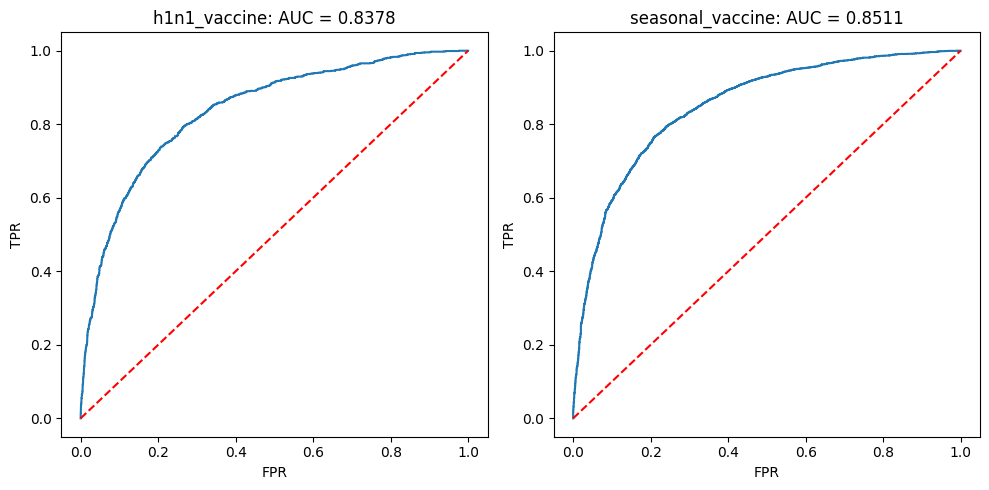

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

In [50]:
estimators.fit(X_train_df, training_set_labels_df)
preds = estimators.predict_proba(X_test_df)
preds

[array([[0.91039485, 0.08960515],
        [0.98022168, 0.01977832],
        [0.54982728, 0.45017272],
        ...,
        [0.84180506, 0.15819494],
        [0.94929854, 0.05070146],
        [0.47186302, 0.52813698]]),
 array([[0.7313161 , 0.2686839 ],
        [0.96870374, 0.03129626],
        [0.32953807, 0.67046193],
        ...,
        [0.78121076, 0.21878924],
        [0.65500946, 0.34499054],
        [0.4835596 , 0.5164404 ]])]

In [51]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.089605,0.268684
26708,0.019778,0.031296
26709,0.450173,0.670462
26710,0.475302,0.885516
26711,0.207778,0.492941


In [52]:
y_preds.to_csv('./results/pred_logistic_regression_output.csv', index = True)